# Is this loss?

The training curves for this model are a little strange. The loss is computed as the sum total MSE over all time samples and channels of the difference signal computed between the model output and the target sequence. The model seems to be preferentially fitting the first section of data, as that's what the decoders seem capable of outputting. Here I'll test a few examples to show how different fits look in loss space.

In [59]:
#!/usr/bin/env python
# coding: utf-8

from aopy import datareader, datafilter
from ecog_is2s import EcogDataloader, Training, Encoder, Decoder, Seq2Seq, Util

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler, BatchSampler, SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split

import spacy
import numpy as np
import pandas as pd
# import sklearn
import scipy as sp

import random
import math
import time

# import progressbar as pb
import datetime
import os
import sys
import pickle as pkl

import argparse
import matplotlib.pyplot as plt

KeyError: 'plotly'

In [43]:
# define constants
T_MINUTES = 2
ENCODER_DEPTH = 250
DECODER_DEPTH = 250
NUM_HID_DIM = 128
BATCH_SIZE = 100
NUM_EPOCHS = 500
N_EPOCHS = NUM_EPOCHS
NUM_LAYERS = 2
RNG_SEED = 5050
INPUT_SEQ_LEN = ENCODER_DEPTH
OUTPUT_SEQ_LEN = DECODER_DEPTH
N_CH_USE = 1
N_LAYER = NUM_LAYERS
N_ENC_LAYERS = N_LAYER
N_DEC_LAYERS = N_LAYER
ENC_DROPOUT = np.float32(0.5)
DEC_DROPOUT = np.float32(0.5)
LEARN_RATE = 0.01 # default ADAM: 0.001
LOSS_OBJ = 'MSE' #L1, L2, see training.py:ECOGLoss()
WEIGHT_RANGE = (-0.2,0.2) # ignore for now; not sure how to worm this through
train_frac = 0.8
test_frac = 0.2
valid_frac = 0.0
# BATCH_SIZE = args.batch_size
# N_EPOCHS = args.num_epochs
CLIP = 1. # this the maximum norm of the whole parameter gradient.
TFR = 0. # no teacher forcing! Anything it's learning is all on its own
RAND_SAMP = False
weight_reg = 0.#0.0003
enc_len = ENCODER_DEPTH
dec_len = DECODER_DEPTH
seq_len = ENCODER_DEPTH+DECODER_DEPTH # use ten time points to predict the next time point

In [44]:
# seed RNG for pytorch/np
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
torch.cuda.manual_seed(RNG_SEED)
torch.backends.cudnn.deterministic = True # enforces deterministic algorithm use -> reproducibility. Remove for production code. You don't do production code. Don't remove.

In [45]:
# set device - CUDA if you've got it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('mounting to device: {}'.format(device))

mounting to device: cpu


In [46]:
# load data
platform_name = sys.platform
if platform_name == 'darwin':
    # local machine
    data_file_full_path = '/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = "/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
    model_save_dir_path = '/Volumes/Samsung_T5/aoLab/Data/models/pyt/seq2seq/'
elif platform_name == 'linux2':
    # HYAK, baby!
    data_file_full_path = '/gscratch/stf/manolan/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = "/gscratch/stf/manolan/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
elif platform_name == 'linux':
    # google cloud, don't fail me now
    data_file_full_path = '/home/mickey/rec001.LM1_ECOG_3.clfp.dat'
    mask_file_path = '/home/mickey/rec001.LM1_ECOG_3.clfp.mask.pkl'
    model_save_dir_path = '/home/mickey/models/pyt/seq2seq/'

# make sure the output directory actually exists
if not os.path.exists(model_save_dir_path):
    os.makedirs(model_save_dir_path)

data_in, data_param, data_mask = datareader.load_ecog_clfp_data(data_file_name=data_file_full_path)
srate_in= data_param['srate']
num_ch = data_param['num_ch']

Loading data file:


In [47]:
# mask data array, remove obvious outliers
data_in[:,np.logical_or(data_mask["hf"],data_mask["sat"])] = 0.

# downsample data
srate_down = 250
srate = srate_in

# grab local time segment
total_len_T = T_MINUTES*60
total_len_n = total_len_T*srate_in
data_idx = data_in.shape[1]//2 + np.arange(total_len_n)
print('Downsampling data from {0} to {1}'.format(srate_in,srate_down))
### note: this breaks mask indexing, if you plan to do that later.
data_in = np.float32(sp.signal.decimate(data_in[:,data_idx],srate_in//srate_down,axis=-1))
print('Data Size:\t{}\n'.format(data_in.shape))

# filter dead channels
ch_rms = np.std(data_in,axis=-1)
ch_m = np.mean(ch_rms)
ch_low_lim = ch_m - 2*np.std(ch_rms)
ch_up_lim = ch_m + 2*np.std(ch_rms)
ch_idx = np.logical_and(ch_rms > ch_low_lim, ch_rms < ch_up_lim)
ch_list = np.arange(num_ch)[ch_idx]
num_ch_down = len(ch_list)
print('Filtering Channels:')
print('Num. ch. used:\t{}'.format(num_ch_down))
print('Ch. kept:\t{}\n'.format(ch_list))

data_in = np.tanh(sp.stats.zscore(data_in[ch_idx,:].view().transpose())/3)

Downsampling data from 1000 to 250
Data Size:	(62, 30000)

Filtering Channels:
Num. ch. used:	56
Ch. kept:	[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57]



In [52]:
loss_assessment_figure_path = './loss_assessment'
os.makedirs('./loss_assessment')

In [48]:
# look at average L1, L2 error across windows
t_window = 1
n_window = t_window*srate_down
n_data = data_in.shape[0]
num_window = n_data // n_window
l2_zero = np.zeros(num_window)
l1_zero = np.zeros(num_window)
for w_i in range(num_window):
    w_start = w_i*n_window
    w_end = w_start + n_window
    l2_zero[w_i] = (data_in[w_start:w_end,:]**2).sum()
    l1_zero[w_i] = np.abs(data_in[w_start:w_end,:]).sum()

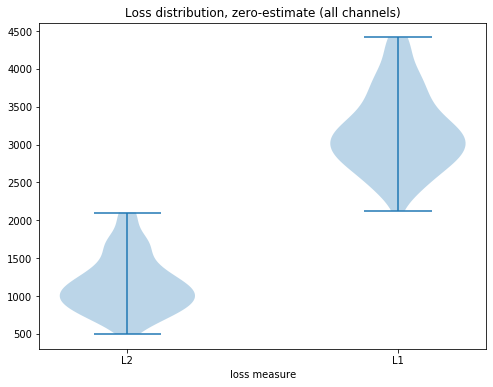

In [57]:
# all channels, 1s windows
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.violinplot((l2_zero,l1_zero),)
plt.xticks([1,2],['L2','L1'])
ax.set_xlabel('loss measure')
ax.set_title('Loss distribution, zero-estimate (all channels)')
f.savefig(os.path.join(loss_assessment_figure_path,'zero_solution_error_distribution.png'))

In [58]:
4000/56*0.04

2.857142857142857